In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import year
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
operations_json = "./Bombing_Operations.json"
craft_json = 'Aircraft_Glossary.json'

In [3]:
session = SparkSession.builder.appName('war').getOrCreate()

23/11/20 02:21:04 WARN Utils: Your hostname, Namans-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.23 instead (on interface en0)
23/11/20 02:21:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/20 02:21:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
session.sparkContext.setLogLevel("ERROR")

In [5]:
# importing datasets
war_df = session.read.json(operations_json)
aircraft_df = session.read.json(craft_json)

### The Bombing_Operations.json file

In [6]:
# contains the following columns
war_df.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- ContryFlyingMission: string (nullable = true)
 |-- MissionDate: string (nullable = true)
 |-- OperationSupported: string (nullable = true)
 |-- PeriodOfDay: string (nullable = true)
 |-- TakeoffLocation: string (nullable = true)
 |-- TargetCountry: string (nullable = true)
 |-- TimeOnTarget: double (nullable = true)
 |-- WeaponType: string (nullable = true)
 |-- WeaponsLoadedWeight: long (nullable = true)



In [7]:
war_df.limit(4).toPandas()

,AirCraft,ContryFlyingMission,MissionDate,OperationSupported,PeriodOfDay,TakeoffLocation,TargetCountry,TimeOnTarget,WeaponType,WeaponsLoadedWeight
0,EC-47,UNITED STATES OF AMERICA,1971-06-05,None,D,TAN SON NHUT,CAMBODIA,1005.0,None,0
1,EC-47,UNITED STATES OF AMERICA,1972-12-26,None,D,NAKHON PHANOM,SOUTH VIETNAM,530.0,None,0
2,RF-4,UNITED STATES OF AMERICA,1973-07-28,None,D,UDORN AB,LAOS,730.0,None,0
3,A-1,UNITED STATES OF AMERICA,1970-02-02,None,N,NAKHON PHANOM,LAOS,1415.0,BLU27 FIRE BOMB (750),17400


### The Aircraft_Glossary.json file

In [8]:
# contains the following columns
aircraft_df.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- AirCraftName: string (nullable = true)
 |-- AirCraftType: string (nullable = true)



In [9]:
aircraft_df.limit(4).toPandas()

,AirCraft,AirCraftName,AirCraftType
0,A-1,Douglas A-1 Skyraider,Fighter Jet
1,A-26,Douglas A-26 Invader,Light Bomber
2,A-37,Cessna A-37 Dragonfly,Light ground-attack aircraft
3,A-4,McDonnell Douglas A-4 Skyhawk,Fighter Jet


### <br><br>Showing the total number of missions for each of the countries involved (according to ContryFlyingMission)

In [10]:
# solving with Dataframe API
mission_by_country = war_df.groupBy('ContryFlyingMission').count().toPandas()
mission_by_country

,ContryFlyingMission,count
0,VIETNAM (SOUTH),622013
1,KOREA (SOUTH),24469
2,UNITED STATES OF AMERICA,3708997
3,AUSTRALIA,12519
4,LAOS,32777


In [11]:
# With Spark SQL
war_df.createOrReplaceTempView("vietnam_war")
session.sql("SELECT ContryFlyingMission, COUNT(*) as Missions FROM vietnam_war GROUP BY ContryFlyingMission").show()


+--------------------+--------+
| ContryFlyingMission|Missions|
+--------------------+--------+
|     VIETNAM (SOUTH)|  622013|
|       KOREA (SOUTH)|   24469|
|UNITED STATES OF ...| 3708997|
|           AUSTRALIA|   12519|
|                LAOS|   32777|
+--------------------+--------+



In [12]:
# With RDD
rdd_war_df = war_df.rdd

grouped_rdd = (
    rdd_war_df
    .map(lambda row: (row["ContryFlyingMission"], 1))  # Map each row to a key-value pair (country, 1)
    .reduceByKey(lambda x, y: x + y)  # Reduce by key (country) by summing up the values
)

# Display the result
for country, count in grouped_rdd.collect():
    print(f"{country}: {count} Missions")

KOREA (SOUTH): 24469 Missions
LAOS: 32777 Missions
UNITED STATES OF AMERICA: 3708997 Missions
VIETNAM (SOUTH): 622013 Missions
AUSTRALIA: 12519 Missions


Among the three I found Dataframe API to be the most efficient one

### Bar chart with the number of missions by country

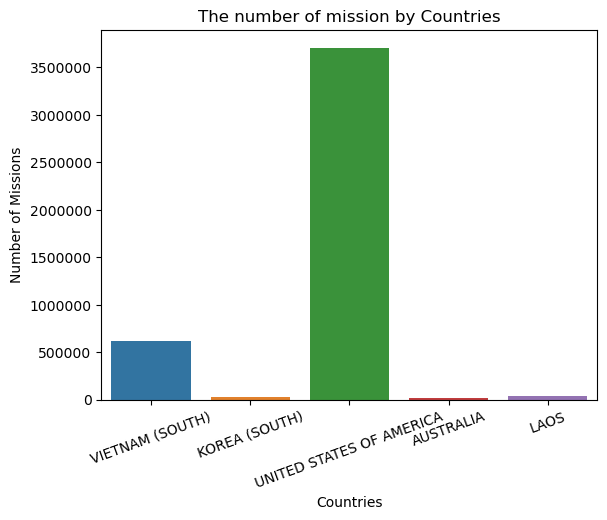

In [13]:
plot = sns.barplot(mission_by_country, x='ContryFlyingMission', y='count')
plot.set_title('The number of mission by Countries')
plot.set_xlabel('Countries')
plot.set_ylabel('Number of Missions')
plot.set_xticklabels(plot.get_xticklabels(), rotation=20)
plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))

[Text(0, 0, 'VIETNAM (SOUTH)'),
 Text(1, 0, 'KOREA (SOUTH)'),
 Text(2, 0, 'UNITED STATES OF AMERICA'),
 Text(3, 0, 'AUSTRALIA'),
 Text(4, 0, 'LAOS')]

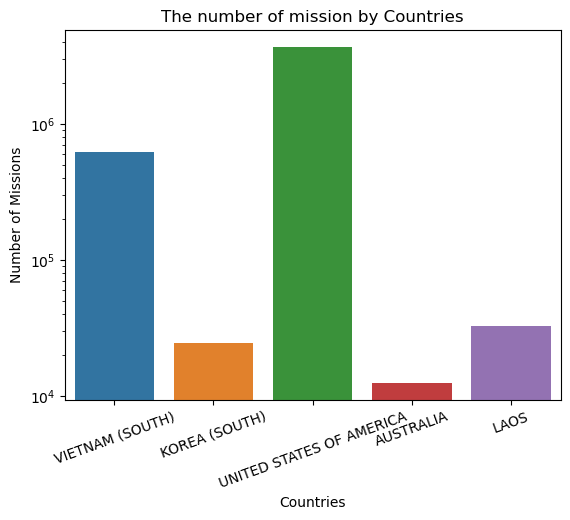

In [14]:
# log scaling bar plot to compare lower count contries better
plot = sns.barplot(mission_by_country, x='ContryFlyingMission', y='count', log=True)
plot.set_title('The number of mission by Countries')
plot.set_xlabel('Countries')
plot.set_ylabel('Number of Missions')
plot.set_xticklabels(plot.get_xticklabels(), rotation=20)

### Number of missions per day for each of the countries involved.

In [15]:
mission_per_day = war_df.groupBy('ContryFlyingMission', year("MissionDate").alias("Year")).count().orderBy("ContryFlyingMission", "Year").toPandas()


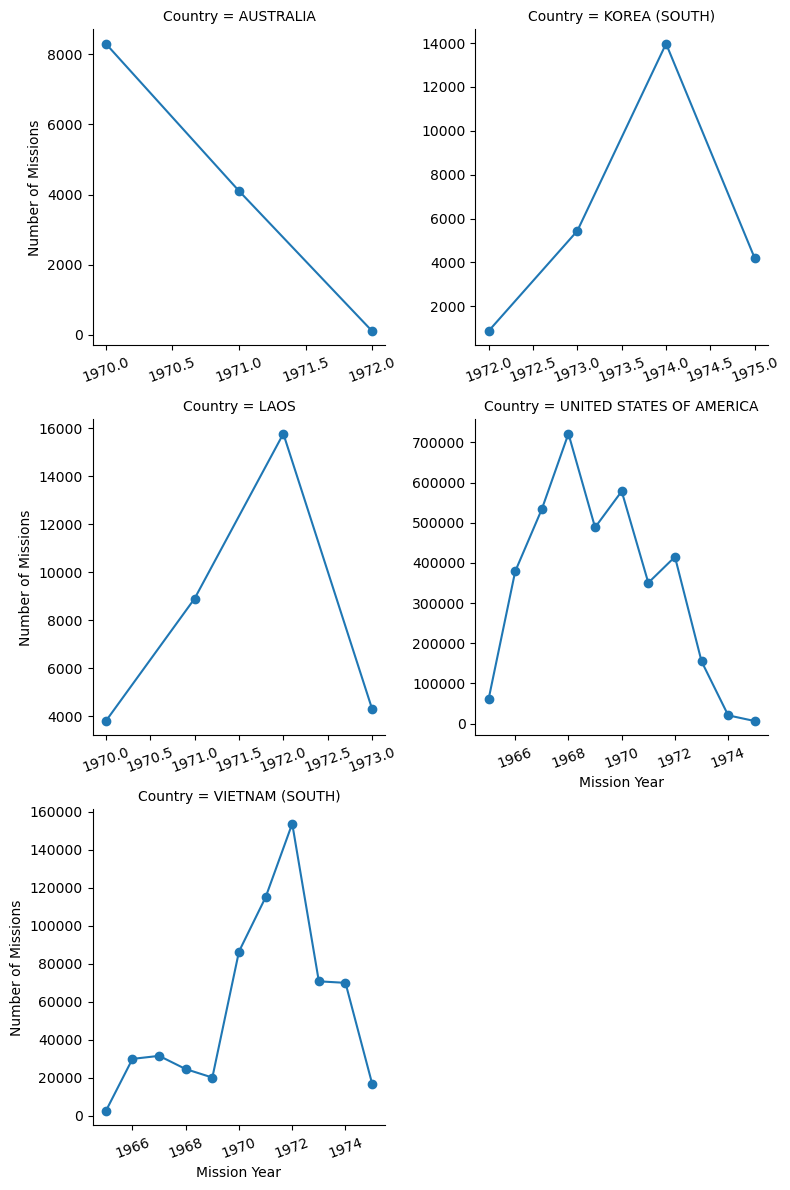

In [16]:
g = sns.FacetGrid(mission_per_day, col="ContryFlyingMission", col_wrap=2, height=4,
                  sharey=False, sharex=False)
g.map(plt.plot, "Year", "count", marker="o")

# Set plot labels and titles
g.set_axis_labels("Mission Year", "Number of Missions")
g.set_titles(col_template="Country = {col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', which='both', rotation=20)
g.fig.tight_layout()

### How many takeoffs were launched to attack North Vietnam on 29 June 1966 from each location?

In [17]:
session.sql("SELECT TakeoffLocation, COUNT(*) as ATTACKS FROM vietnam_war WHERE TRIM(MissionDate)='1966-06-29'\
            AND TargetCountry = 'NORTH VIETNAM' GROUP BY TakeoffLocation").show()

+----------------+-------+
| TakeoffLocation|ATTACKS|
+----------------+-------+
|          DANANG|     35|
|        UDORN AB|     44|
|HANCOCK (CVA-19)|     10|
|   CONSTELLATION|     87|
|          TAKHLI|     56|
|          RANGER|     35|
|           KORAT|     55|
|         UBON AB|     44|
|    TAN SON NHUT|     26|
|         CUBI PT|      1|
|    CAM RANH BAY|      2|
+----------------+-------+



In total 395 attacks happened on North Vietnam on the 29th of June, 1966

### Which campaigns saw the heaviest bombings?

In [18]:
session.sql("SELECT OperationSupported, COUNT(*) FROM VIETNAM_WAR WHERE OperationSupported IS NOT NULL\
            GROUP BY OperationSupported ORDER BY COUNT(*) DESC LIMIT 1").show()

+------------------+--------+
|OperationSupported|count(1)|
+------------------+--------+
|        IN COUNTRY|  546215|
+------------------+--------+



### Which month saw the highest number of missions?

In [19]:
session.sql("""
    SELECT
        CASE
            WHEN month = '01' THEN 'January'
            WHEN month = '02' THEN 'February'
            WHEN month = '03' THEN 'March'
            WHEN month = '04' THEN 'April'
            WHEN month = '05' THEN 'May'
            WHEN month = '06' THEN 'June'
            WHEN month = '07' THEN 'July'
            WHEN month = '08' THEN 'August'
            WHEN month = '09' THEN 'September'
            WHEN month = '10' THEN 'October'
            WHEN month = '11' THEN 'November'
            WHEN month = '12' THEN 'December'
            ELSE 'Unknown'
        END AS month_name,
        missions
    FROM (
        SELECT
            SPLIT_PART(MISSIONDATE, '-', 2) as month,
            COUNT(*) as missions
        FROM
            VIETNAM_WAR
        GROUP BY
            SPLIT_PART(MISSIONDATE, '-', 2) LIMIT 1)
    ORDER BY
        missions DESC
""").show()


+----------+--------+
|month_name|missions|
+----------+--------+
|      July|  339555|
+----------+--------+



### What was the most used aircraft type during the war?

In [20]:
war_used_crafts = war_df.join(aircraft_df, on='AirCraft').select(['AirCraft', 'AirCraftType'])

In [21]:
war_used_crafts.show(5)

+--------+--------------------+
|AirCraft|        AirCraftType|
+--------+--------------------+
|   EC-47|Military Transpor...|
|   EC-47|Military Transpor...|
|    RF-4|  Fighter bomber jet|
|     A-1|         Fighter Jet|
|    A-37|Light ground-atta...|
+--------+--------------------+
only showing top 5 rows



In [22]:
war_used_crafts.groupby('AirCraftType').count().orderBy(F.desc('count')).limit(1).show()

+------------------+-------+
|      AirCraftType|  count|
+------------------+-------+
|Fighter Jet Bomber|1073126|
+------------------+-------+



"Fighter Jet Bomber" was the most used AirCraft Type